# PAL: 2-D Simulation Study

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from doe import lhd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sim_funcs import two_dim_f
from itertools import product
from partitioned_gp import PGP
from active_learning import ActiveLearningMachine
from strategy_lib import max_entropy, imse, pimse, max_distance, random_sample

%matplotlib inline
warnings.filterwarnings('ignore')

### Experiment Setting

In [2]:
# Experiment setting
n0 = 15
n_max = 30
budget = n_max - n0
n_rep = 10
np.random.seed(1)

# default GP
kernel = ConstantKernel(constant_value_bounds=(1e-5, 5.)) * RBF(length_scale_bounds=(1e-3, 10.))\
                        + WhiteKernel(noise_level_bounds=(1e-5, 1e-3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)

# default PGP
pgp = PGP(kernel, n_partitions=2, seed=0)

### Data Preparation

In [3]:
# Data for evaluation
XY = np.array(list(product(np.linspace(0, 1, 100), np.linspace(0, 1, 100))))
XX, YY = XY[:, 0].reshape(100, 100), XY[:, 1].reshape(100, 100)
ZZ = two_dim_f(XY)
XZ_test = (XY, ZZ)
X_ref = np.load('lhd_1000_2.npy')

X_init_set = []
Z_init_set = []
for i in range(n_rep):
    X_init = lhd(n0, 2, criterion='maximin', seed=np.random.randint(9999))
    X_init_set.append(X_init)
    Z_init_set.append(two_dim_f(X_init, noise=True))

In [4]:
passive_prog = np.zeros((n_rep, budget+1))
passive_time = np.zeros(n_rep)

for i in range(n_rep):
    passive = ActiveLearningMachine(gp, random_sample, budget, XZ_test)
    X_init = X_init_set[i].copy()
    Z_init = Z_init_set[i].copy()
    passive.init_fit(X_init, Z_init)
    for j in range(budget):
        x_new = passive.query(XY)
        passive.update(x_new, two_dim_f(x_new, noise=True))
    passive_prog[i] = passive.prog
    passive_time[i] = passive.time

In [5]:
md_prog = np.zeros((n_rep, budget+1))
md_time = np.zeros(n_rep)

for i in range(n_rep):
    md = ActiveLearningMachine(gp, max_distance, budget, XZ_test)
    X_init = X_init_set[i].copy()
    Z_init = Z_init_set[i].copy()
    md.init_fit(X_init, Z_init)
    for j in range(budget):
        x_new = md.query(XY)
        md.update(x_new, two_dim_f(x_new, noise=True))
    md_prog[i] = md.prog
    md_time[i] = md.time

In [6]:
alm_prog = np.zeros((n_rep, budget+1))
alm_time = np.zeros(n_rep)

for i in range(n_rep):
    alm = ActiveLearningMachine(gp, max_entropy, budget, XZ_test)
    X_init = X_init_set[i].copy()
    Z_init = Z_init_set[i].copy()
    alm.init_fit(X_init, Z_init)
    for j in range(budget):
        x_new = alm.query(XY)
        alm.update(x_new, two_dim_f(x_new, noise=True))
    alm_prog[i] = alm.prog
    alm_time[i] = alm.time

In [7]:
alc_prog = np.zeros((n_rep, budget+1))
alc_time = np.zeros(n_rep)

for i in range(n_rep):
    alc = ActiveLearningMachine(gp, imse, budget, XZ_test)
    X_init = X_init_set[i].copy()
    Z_init = Z_init_set[i].copy()
    alc.init_fit(X_init, Z_init)
    for j in range(budget):
        x_new = alc.query(XY, False, (X_ref))
        alc.update(x_new, two_dim_f(x_new, noise=True))
    alc_prog[i] = alc.prog
    alc_time[i] = alc.time

In [8]:
pal_prog = np.zeros((n_rep, budget+1))
pal_time = np.zeros(n_rep)

for i in range(n_rep):
    pal = ActiveLearningMachine(pgp, pimse, budget, XZ_test)
    X_init = X_init_set[i].copy()
    Z_init = Z_init_set[i].copy()
    pal.init_fit(X_init, Z_init)
    for j in range(budget):
        x_new = pal.query(XY, False, (X_ref))
        pal.update(x_new, two_dim_f(x_new, noise=True))
    pal_prog[i] = pal.prog
    pal_time[i] = pal.time

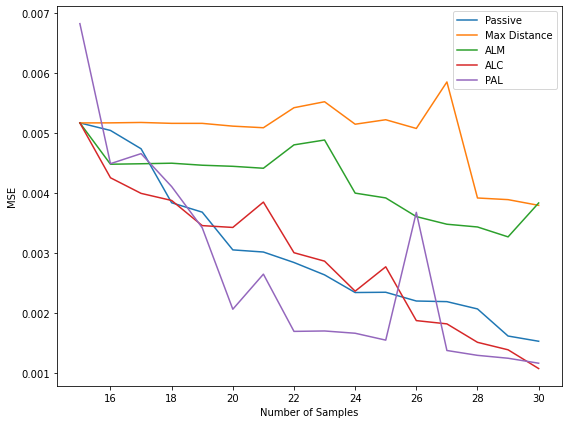

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(n0, n_max+1), passive_prog.mean(axis=0), label='Passive')
plt.plot(np.arange(n0, n_max+1), md_prog.mean(axis=0), label='Max Distance')
plt.plot(np.arange(n0, n_max+1), alm_prog.mean(axis=0), label='ALM')
plt.plot(np.arange(n0, n_max+1), alc_prog.mean(axis=0), label='ALC')
plt.plot(np.arange(n0, n_max+1), pal_prog.mean(axis=0), label='PAL')
plt.xlabel('Number of Samples')
plt.ylabel('MSE')
plt.legend(); plt.tight_layout()
plt.show()

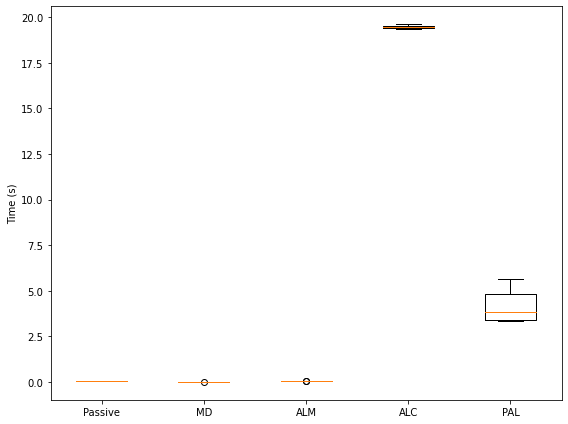

In [10]:
time = np.array([passive_time, md_time, alm_time, alc_time, pal_time]).T
plt.figure(figsize=(8, 6))
plt.boxplot(time)
plt.xticks([1, 2, 3, 4, 5], ['Passive', 'MD', 'ALM', 'ALC', 'PAL'])
plt.ylabel('Time (s)')
plt.tight_layout(); plt.show()